# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

## Предобработка данных

In [757]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [758]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [759]:
# Приводим названия столбцов к каноничному виду

data.rename(columns={'cityCenters_nearest': 'city_centers_nearest','parks_around3000':'parks_around_3000','ponds_around3000':'ponds_around_3000'}, inplace = True)

In [760]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

необходимо сменить тип данных для: 
last_price, - удобнее оперировать в расчетах с форматом значения int64
first_day_exposition, - с датами удобнее работать в формате datetime
floors_total - чутье подсказывает, что кол-во этажей не может быть дробным
is_apartment - думаю, стоит перевести в boolean тип
days_exposition - удобнее работать с целечисленной переменной 


In [761]:
data['last_price'] = data['last_price'].astype('int64')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].astype('bool')

#data['days_exposition'] = data['days_exposition'].astype('int64') # пока ошибка, попробую позже разобраться
#data['floors_total'] = data['floors_total'].astype('int64') # то же самое
#data['days_exposition'] = data['days_exposition'].fillna(0).astype(int) #рабочий вариант

try:
    data['floors_total'] = data['floors_total'].astype('int64')
    data['days_exposition'] = data['days_exposition'].fillna(0).astype(int) #заполняем пропуски 0 и переводим в int
    
except:
    pass

try:
    data['city_centers_nearest'] =  data['city_centers_nearest'].fillna(0).astype(int)
except:
    pass

[Text(0.5, 1.0, 'количество пропусков в days_exposition'),
 Text(0.5, 0, 'год'),
 Text(0, 0.5, 'количество пропусков')]

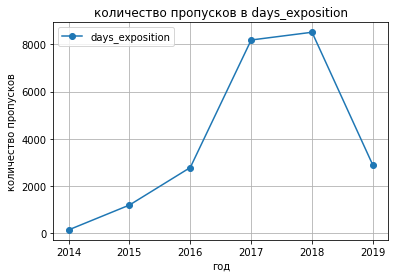

In [762]:
# Чтобы выявить пропуски, мне пришлось их промаркировать - сделать их аномальными - 
# присвоил им значение 9999 - так их лучше будет видно на графике

data_new = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

#data_new['days_exposition'] = data_new['days_exposition'].fillna(9999).astype(int)
#data['days_exposition'] = data['days_exposition'].astype(int)


try:
    data_new['days_exposition'].fillna(9999, inplace=True).astype(int)
    #data_new['days_exposition'] = data_new['days_exposition'].astype(int)
    
except:
    pass


data_new['first_day_exposition'] = pd.to_datetime(data_new['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data_new['year'] = data_new['first_day_exposition'].dt.year

data_new.pivot_table(index='year', values='days_exposition', aggfunc='count').reset_index().plot(
                      x='year', y='days_exposition', grid=True, style='o-').set(
                      title='количество пропусков в days_exposition', 
                      xlabel='год', ylabel='количество пропусков')

Text(0, 0.5, 'количество пропусков')

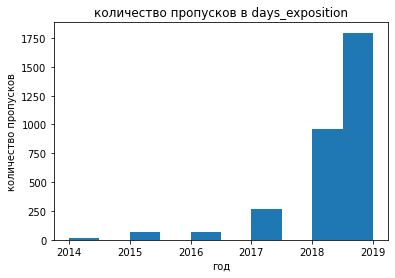

In [763]:
import matplotlib.pyplot as plt

plt.hist(data_new.query('days_exposition==9999')['year'])
plt.title('количество пропусков в days_exposition')
plt.xlabel('год')
plt.ylabel('количество пропусков')

In [764]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [765]:
data.isna().sum() # считаем пропущеные значения

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest        0
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

'ceiling_height           9195 - не указали высоту потолков, думаю, оставить или попробовать разобраться и исправить некоторые значения
floors_total               86 - не указали, могут быть одноэтажные, если нет, то думаю удалить
living_area              1903 - удалить
'kitchen_area             2278 - вероятно, апартаменты, если так, то оставить Null 
'balcony                 11519 - вероятно, просто отсутствует, думаю, стоит заменить на 0
locality_name              49 - удалить
airports_nearest         5542 - эти пропуски думаю оставить
city_centers_nearest     5519 - эти так же
parks_around3000         5518 - пропуски вероятно связаны с отсутствием
parks_nearest           15620 - и здесь, думаю заполнить на 0
ponds_around3000         5518 - пропуски вероятно связаны с отсутствием
ponds_nearest           14589 - и здесь, думаю заполнить на 0
days_exposition          3181 - думаю оставить

In [766]:
# Устраняем пропуски 

data['is_apartment'] = data['is_apartment'].fillna('False') #вероятно, где пропуски - не являются апартаментами -
# заполнил на соответствующее значение

'''try:
    data.query('floors_total != 1')['floors_total'].dropna(inplace=True)
except:
    print('error')''' #ошибка при выполнении, решил дропнуть значения 

#data['floors_total'] = data['floors_total'].fillna(0) #идея заполнять пропуски 0-этажными зданиями - была плохая 

#data['floors_total'].dropna(inplace=True) - остаются пропуски
#data['living_area'].dropna(inplace=True) - остаются пропуски
data.drop(index=data.query('floors_total. isna()').index,inplace=True) #
data.drop(index=data.query('living_area. isna()').index,inplace=True)

data['balcony'] = data['balcony'].fillna(0)

#data['locality_name'].dropna(inplace=True)
data.drop(index=data.query('locality_name. isna()').index,inplace=True)

data['parks_around_3000'] = data['parks_around_3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)

data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

#data['days_exposition'] = data['days_exposition'].fillna(0)
#data['days_exposition'] = data['days_exposition'].fillna(0).astype(int)

In [767]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          8013
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             795
balcony                    0
locality_name              0
airports_nearest        4906
city_centers_nearest       0
parks_around_3000          0
parks_nearest              0
ponds_around_3000          0
ponds_nearest              0
days_exposition         2976
dtype: int64

In [768]:
print('уникальных назнаний населенных пунктов:' ,data['locality_name'].unique().shape[0])
data['locality_name'].unique()

уникальных назнаний населенных пунктов: 348


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'село Путилово', 'Ивангород', 'Мурино',
       'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское', 'Зеленогорск',
       'Сосновый Бор',

In [769]:
data.duplicated().sum()

0

In [770]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,21700.000000,2.170000e+04,21700.000000,21700.000000,13687.000000,21700.000000,21700.000000,21700.000000,20905.000000,21700.000000,16794.000000,21700.000000,21700.000000,21700.000000,21700.000000,21700.000000,18724.000000
mean,10.029355,6.499828e+06,60.061487,2.071567,2.773037,10.648065,34.454822,5.877051,10.509280,0.617788,28774.283256,11034.118848,0.473088,167.969677,0.592396,200.078664,184.742897
std,5.676967,1.088467e+07,34.698564,1.080600,1.295796,6.566794,22.045359,4.855324,5.841913,0.968415,12658.163182,9676.680221,0.749742,305.180293,0.884493,305.813937,221.370959
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,3.450000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18516.500000,2753.250000,0.000000,0.000000,0.000000,0.000000,44.000000
50%,10.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26709.000000,11382.000000,0.000000,0.000000,0.000000,0.000000,101.000000
75%,14.000000,6.750000e+06,69.500000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37234.000000,15277.250000,1.000000,304.000000,1.000000,393.000000,238.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [771]:
print('квартир с площадью в диапазоне от 0 до 100 кв м.:', data.query('0 < total_area < 100')['total_area'].count())
print('квартир с площадью в диапазоне от 100 до 150 кв м.:', data.query('100 < total_area < 150')['total_area'].count())
print('квартир с площадью в диапазоне от 150 до 200 кв м.:', data.query('150 < total_area < 200')['total_area'].count())
print('квартир с площадью в диапазоне от 200 до 1000 кв м.:', data.query('200 < total_area < 1000')['total_area'].count())

квартир с площадью в диапазоне от 0 до 100 кв м.: 19992
квартир с площадью в диапазоне от 100 до 150 кв м.: 1134
квартир с площадью в диапазоне от 150 до 200 кв м.: 293
квартир с площадью в диапазоне от 200 до 1000 кв м.: 198


array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

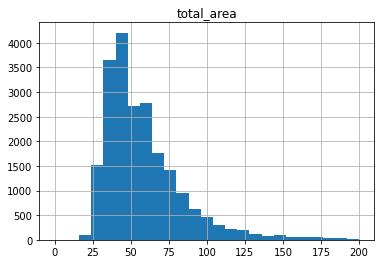

In [772]:
data.hist('total_area', bins=25, range=(0,200))

In [773]:
print('квартир с площадью в диапазоне от 0 до 25 кв м.:', data.query('0 < total_area < 25')['total_area'].count())
print()

print('студий всего:', data.query('studio==True')['studio'].count())
print('студии с площадью в диапазоне от 0 до 25 кв м.:', data.query('0 < total_area < 25 and studio==True')['total_area'].count())
print()

print('апартаментов всего:', data.query('is_apartment==True')['is_apartment'].count())
print('апартаменты с площадью в диапазоне от 0 до 25 кв м.:', data.query('0 < total_area < 25 and is_apartment==True')['total_area'].count())

квартир с площадью в диапазоне от 0 до 25 кв м.: 159

студий всего: 139
студии с площадью в диапазоне от 0 до 25 кв м.: 46

апартаментов всего: 19100
апартаменты с площадью в диапазоне от 0 до 25 кв м.: 144


In [774]:
# удаляем квартиры площадью менее 25 кв м и более 200 кв м 

#data.drop(index=data.query('total_area < 25').index,inplace=True)
#data.drop(index=data.query('total_area > 200').index,inplace=True)

In [775]:
print('Площадь менее 25:',data_new.query('total_area <= 25')['rooms'].count())
print('Площадь менее 25:',data_new.query('total_area >= 200')['rooms'].count())

Площадь менее 25: 235
Площадь менее 25: 231


array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

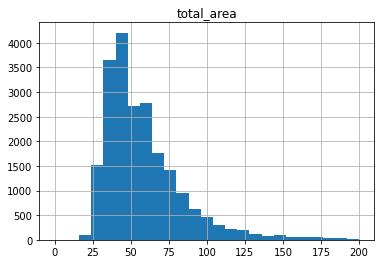

In [776]:
data.hist('total_area', bins=25, range=(0,200))

In [777]:
# Смотрим количество комнат

print('Без комнат:',data.query('rooms == 0')['rooms'].count()) 
print('Без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 
print('Без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 
print('Без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())

Без комнат: 183
Без комнат и студии: 128
Без комнат и апартаменты: 177
Без комнат и свободная планировка: 55


In [778]:
#Удаляем не студии без комнат и не апартаменты без комнат

data.drop(index=data.query('rooms == 0 and studio==False').index,inplace=True)
data.drop(index=data.query('rooms == 0 and is_apartment==False').index,inplace=True)

data.drop(index=data.query('rooms == 0').index,inplace=True)
print('Без комнат:',data.query('rooms == 0')['rooms'].count())

Без комнат: 0


In [779]:
print('свободная планировка:',data_new.query('open_plan==True')['open_plan'].count())
print('Без комнат:',data_new.query('rooms==0')['rooms'].count())
print()

print('комат не 0 и студия:',data_new.query('rooms !=0 and studio==True')['rooms'].count())
print('комат не 0 и св пл:',data_new.query('rooms !=0 and open_plan==True')['rooms'].count())

print('комат 0 и студия:',data_new.query('rooms ==0 and studio==True')['rooms'].count())
print('комат 0 и св пл:',data_new.query('rooms ==0 and open_plan==True')['rooms'].count())

свободная планировка: 67
Без комнат: 197

комат не 0 и студия: 11
комат не 0 и св пл: 8
комат 0 и студия: 138
комат 0 и св пл: 59


In [780]:
print('кол-во комнат в студиях:',data_new.query('rooms !=0 and studio==True')['rooms'].unique())
print('кол-во комнат в отк. пл-ах:',data_new.query('rooms !=0 and open_plan==True')['rooms'].unique())
print('кол-во комнат в апартаментах:',data_new.query('rooms !=0 and is_apartment==True')['rooms'].unique())

кол-во комнат в студиях: [1]
кол-во комнат в отк. пл-ах: [1 3 2 5 4]
кол-во комнат в апартаментах: [2 1 3 5 7 4]


In [781]:
# Смотрим наличие кухни

print('С кухней:',data.query('~kitchen_area.isna()')['living_area'].count())
print('Без кухни:',data.query('kitchen_area.isna()')['living_area'].count())



С кухней: 20905
Без кухни: 612


In [782]:
print('Студии без кухни:',data.query('kitchen_area.isna() and studio==True')['living_area'].count())
print('Апар-ты без кухни:',data.query('kitchen_area.isna() and is_apartment==True')['living_area'].count())
print()

data.drop(index=data.query('(kitchen_area.isna() and ~studio==True) and (kitchen_area.isna() and ~is_apartment==True)').index,inplace=True)

print('дропаем не апартаменты и не студии без кухни')
#data.drop(index=data.query('kitchen_area.isna()').index,inplace=True)

print('проверяем')
print()
print('С кухней:',data.query('~kitchen_area.isna()')['living_area'].count())
print('Без кухни:',data.query('kitchen_area.isna()')['living_area'].count())


Студии без кухни: 11
Апар-ты без кухни: 510

дропаем не апартаменты и не студии без кухни
проверяем

С кухней: 20905
Без кухни: 520


In [783]:
# Очищаем оставшиеся

data.drop(index=data.query('kitchen_area.isna()').index,inplace=True)
print('С кухней:',data.query('~kitchen_area.isna()')['living_area'].count())
print('Без кухни:',data.query('kitchen_area.isna()')['living_area'].count())

С кухней: 20905
Без кухни: 0


*Устранили пропуски и аномалии в наличиях комнат*

кухня больше 30 м.: 360


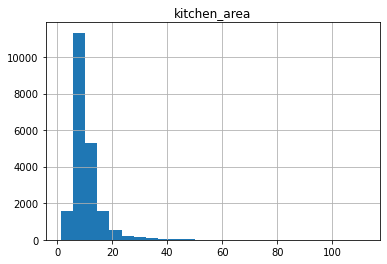

In [784]:
# Распределение площадей кухонь 

data.hist('kitchen_area', bins=25)

print('кухня больше 30 м.:',data.query('kitchen_area >= 30')['kitchen_area'].count()) 

<AxesSubplot:xlabel='total_area', ylabel='living_area'>

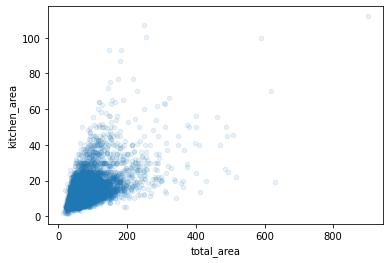

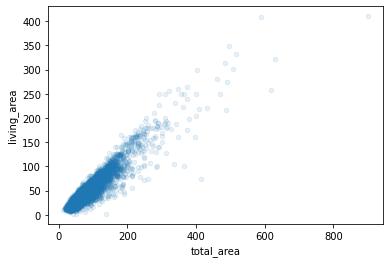

In [785]:
data.plot(x='total_area', y='kitchen_area', kind='scatter', alpha=0.1)
data.plot(x='total_area', y='living_area', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='total_area', ylabel='living_area'>

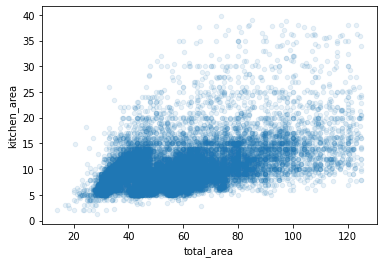

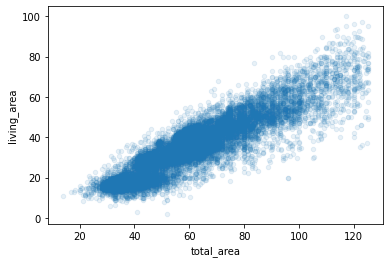

In [786]:
# Видна корреляция между общей площадью и жилой площадью, однако 
# кореляция между общей площадью и площадью кухни выражена не так явно 
# Удаляем редкие и выбивающиеся значения 

data.drop(index=data.query('kitchen_area >= 40').index,inplace=True)

data.drop(index=data.query('total_area > 75 and living_area < 20').index,inplace=True)
data.drop(index=data.query('total_area > 100 and living_area < 30').index,inplace=True)
data.drop(index=data.query('total_area > 125 and kitchen_area < 40').index,inplace=True)

data.drop(index=data.query('total_area > 100 and living_area < 10').index,inplace=True)
data.drop(index=data.query('total_area > 125 and living_area < 15').index,inplace=True)
data.drop(index=data.query('total_area > 150 and living_area < 20').index,inplace=True)


data.plot(x='total_area', y='kitchen_area', kind='scatter', alpha=0.1)
data.plot(x='total_area', y='living_area', kind='scatter', alpha=0.1)

*Устранили аномалии с живой площадью и кухней*

квартир с ценеой менее 1 млн: 173
квартир с ценеой более 10 млн: 1549
квартир с ценеой более 100 млн: 1
квартир с ценеой более 500 млн: 0


array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

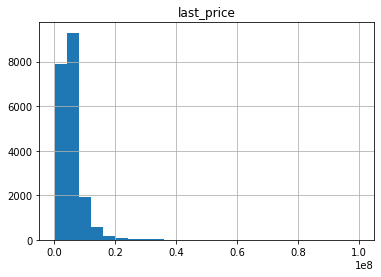

In [787]:
# Смотрим цены цены квартир

print('квартир с ценеой менее 1 млн:',data.query('last_price < 1.0e+6')['last_price'].count())
print('квартир с ценеой более 10 млн:',data.query('last_price > 1.0e+7')['last_price'].count())
print('квартир с ценеой более 100 млн:',data.query('last_price > 1.0e+8')['last_price'].count())
print('квартир с ценеой более 500 млн:',data.query('last_price > 500*1.0e+6')['last_price'].count())

data.hist('last_price', bins=25, range=(1.0e+5,100.0e+6))

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

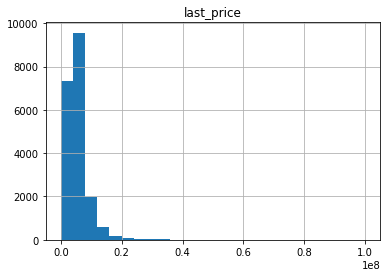

In [788]:
# Удаляем квартиры с ценой менее 1 млн и более 100 млн

data.drop(index=data.query('last_price <= 1.0e+6').index,inplace=True)
data.drop(index=data.query('last_price >= 100.0e+6').index,inplace=True)

data.hist('last_price', bins=25, range=(0,100.0e+6))

*Устранили аномалии с ценами*

In [789]:
# Смотрим высоту потолков

print('Потолки до 4 м:', data.query('ceiling_height < 4')['ceiling_height'].count())
print('Потолки от 4 до 25 м:', data.query('4 < ceiling_height < 25')['ceiling_height'].count())
print('Потолки от 25 м: ', data.query('ceiling_height > 25')['ceiling_height'].count())
print('Потолки от 50 м: ', data.query('ceiling_height > 50')['ceiling_height'].count())
print('Потолки от 75 м: ', data.query('ceiling_height > 75')['ceiling_height'].count())


Потолки до 4 м: 12546
Потолки от 4 до 25 м: 31
Потолки от 25 м:  11
Потолки от 50 м:  1
Потолки от 75 м:  1


array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

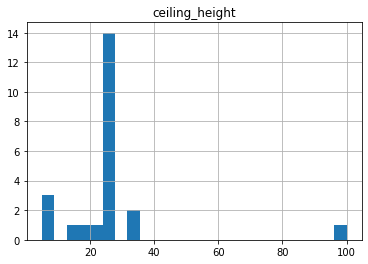

In [790]:
data.hist('ceiling_height', bins=25, range=(5,100))

In [791]:
#Удаляем, где потолки от 4 до 25 м, а так же больше 40
#Там, где диапазон от 25 до 40, вероятно, пропустили запятую и реалная высота от 2.5 до 4, поэтому исправим это 

data.drop(index = data.query('4 > ceiling_height > 25').index, inplace = True)
data.update(data[(data['ceiling_height'] < 40) & (data['ceiling_height'] > 25)]['ceiling_height'] / 10)
data.drop(index = data.query('ceiling_height > 40').index, inplace = True)

*Исправили аномалии с высотой потолков, удалил неподдающиеся исправлению значения*

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

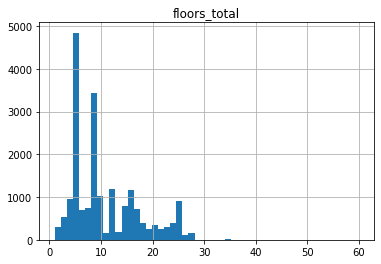

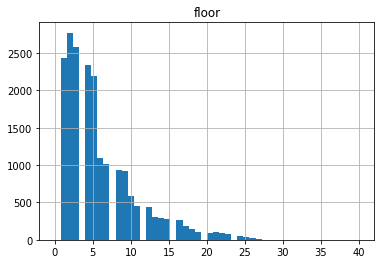

In [792]:
# Смотрим распределение этажей

data.hist('floors_total', bins=50)
data.hist('floor', bins=50, range=(0,40))

array([[<AxesSubplot:title={'center':'balcony'}>]], dtype=object)

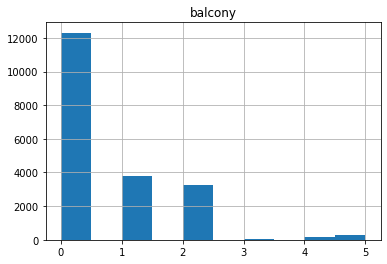

In [793]:
# Смотрим балконы

data.hist('balcony')

*Аномалий с наличием балконов и их площадью нет*

<AxesSubplot:ylabel='Frequency'>

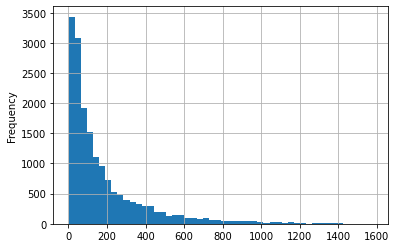

In [794]:
# Смотрим "время жизни" объявления

display(data['days_exposition'].plot(kind='hist', bins=50, grid=True))

*Распределение времени жизни объявлений выглядит нормальным*

In [795]:
# Считаем процент удаленных данных
data_raw=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data_loss = len(data)/len(data_raw)*100
data_loss

83.72927127726908

*Провели предобработку данных, устранили пропуски в столбцах, где это было необходимо, привели названия столбцов и их тип к практичному виду и типу данных, исправили аномальные значения, где это было необходимо* 

## Посчитайте и добавьте в таблицу новые столбцы

In [796]:
#Цена одного квадратного метра
data['price_per_kvm'] = data['last_price'] / data['total_area']

#день недели публикации объявления
data['week_day'] = data['first_day_exposition'].dt.weekday
#dayofweek
#месяц публикации объявления
data['month'] = data['first_day_exposition'].dt.month
#год публикации объявления
data['year'] = data['first_day_exposition'].dt.year

#функция определения типа этажа (первый-последний-другой)
def floor_group(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    else:
        return 'Другой'
data['floor_type'] = data.apply(floor_group, axis=1)


# Добавляем столбец с расстоянием до центра в км, округляем до целого
#расстояние до центра города - ошибка - пока не понимаю, почему не конвертируется
#data['city_center'] = data['city_centers_nearest'].astype('Int64')

data['center_long'] = data['city_centers_nearest'] / 1000
data['center_long'] = data['center_long'].fillna(value=0).astype(int)


# Добавляем столбец с расстоянием до парка в км, округляем до целого
data['park_center'] = data['parks_nearest'] / 1000
data['park_center'] = data['park_center'].fillna(0).astype(int)

# Добавляем столбец с расстоянием до пруда в км, округляем до целого
data['pond_center'] = data['ponds_nearest'] / 1000
data['pond_center'] = data['pond_center'].fillna(0).astype(int)

# Добавляем столбец с расстоянием до аэропорта в км, округляем до целого 
data['airport_center'] = data['airports_nearest'] / 1000
data['airport_center'] = data['airport_center'].fillna(0).astype(int)

## Проведите исследовательский анализ данных

In [797]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,ponds_nearest,days_exposition,price_per_kvm,week_day,month,year,center_long,park_center,pond_center,airport_center
count,19843.000000,1.984300e+04,19843.000000,19843.000000,12614.000000,19843.00000,19843.000000,19843.000000,19843.000000,19843.000000,...,19843.000000,17240.000000,19843.000000,19843.000000,19843.000000,19843.000000,19843.000000,19843.000000,19843.000000,19843.000000
mean,10.037494,5.501560e+06,55.618169,1.996120,2.717952,10.72615,31.774541,5.885955,9.923700,0.627375,...,198.437182,181.511427,97016.821482,2.545532,6.428766,2017.364411,10.960591,0.019805,0.015119,21.988409
std,5.620432,3.605477e+06,20.258685,0.900411,0.604701,6.55101,14.093305,4.844372,4.196287,0.969674,...,306.545966,218.540519,36475.500278,1.784669,3.468319,1.034920,9.602867,0.170855,0.122028,16.359008
min,0.000000,1.010000e+06,14.000000,1.000000,1.000000,1.00000,2.000000,1.000000,1.300000,0.000000,...,0.000000,1.000000,13483.146067,0.000000,1.000000,2014.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,3.499000e+06,40.000000,1.000000,2.500000,5.00000,18.500000,2.000000,7.000000,0.000000,...,0.000000,44.000000,77016.018623,1.000000,3.000000,2017.000000,3.000000,0.000000,0.000000,10.000000
50%,10.000000,4.600000e+06,51.000000,2.000000,2.640000,9.00000,30.000000,4.000000,9.000000,0.000000,...,0.000000,99.000000,94565.217391,2.000000,6.000000,2017.000000,11.000000,0.000000,0.000000,21.000000
75%,14.000000,6.450000e+06,67.000000,3.000000,2.780000,16.00000,41.000000,8.000000,11.360000,1.000000,...,389.000000,232.000000,112542.338456,4.000000,10.000000,2018.000000,15.000000,0.000000,0.000000,34.000000
max,50.000000,8.200000e+07,125.000000,7.000000,25.000000,60.00000,100.000000,33.000000,39.700000,5.000000,...,1344.000000,1580.000000,721518.987342,6.000000,12.000000,2019.000000,65.000000,3.000000,1.000000,84.000000


count    1.984300e+04
mean     5.501560e+06
std      3.605477e+06
min      1.010000e+06
25%      3.499000e+06
50%      4.600000e+06
75%      6.450000e+06
max      8.200000e+07
Name: last_price, dtype: float64

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

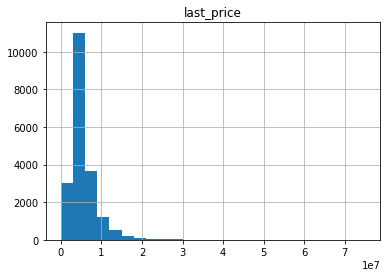

In [798]:
# Изучаем цены недвижимости

display(data['last_price'].describe())
data.hist('last_price', bins=25, range=(0,75*1.0e+6),grid=True)

*Средняя цена квартир составляем 6,5 млн., а медианное значение составляет 4,65 млн.*

count    19843.000000
mean        55.618169
std         20.258685
min         14.000000
25%         40.000000
50%         51.000000
75%         67.000000
max        125.000000
Name: total_area, dtype: float64

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

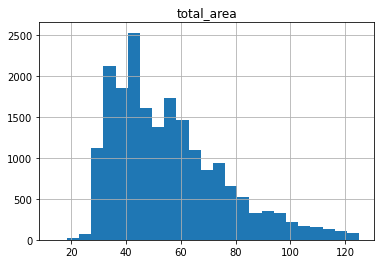

In [799]:
# Изучаем общую площадь

display(data['total_area'].describe())
data.hist('total_area', bins=25, grid=True)

*Средняя площадь квартир составляем 60 кв.м., а медианное значение 52 кв.м.*

count    19843.000000
mean        31.774541
std         14.093305
min          2.000000
25%         18.500000
50%         30.000000
75%         41.000000
max        100.000000
Name: living_area, dtype: float64

<AxesSubplot:ylabel='Frequency'>

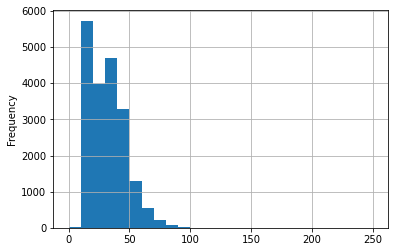

In [800]:
# Изучаем живую площадь

display(data['living_area'].describe())
data['living_area'].plot(kind='hist', bins=25, range=(0,250), grid=True)

*Средняя живая площадь квартир составляем 34 кв.м., а медианное значение 30 кв.м.*

count     19843.000000
mean      97016.821482
std       36475.500278
min       13483.146067
25%       77016.018623
50%       94565.217391
75%      112542.338456
max      721518.987342
Name: price_per_kvm, dtype: float64

<AxesSubplot:ylabel='Frequency'>

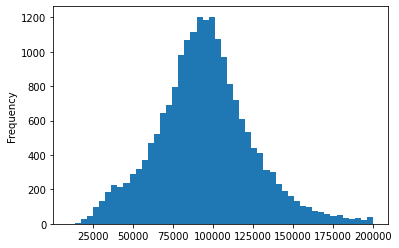

In [801]:
# Изучаем стоимость квадратного метра 

display(data['price_per_kvm'].describe())
data['price_per_kvm'].plot(kind='hist', range=(10000,200000),bins=50)

*Значение средней цены имеет нормально распределение, значения выше 170 тыс за кв. м встречаются довольно редно, пиковое значение лежит в районе 100 тыс за кв. м*

count    19843.000000
mean         9.923700
std          4.196287
min          1.300000
25%          7.000000
50%          9.000000
75%         11.360000
max         39.700000
Name: kitchen_area, dtype: float64

<AxesSubplot:ylabel='Frequency'>

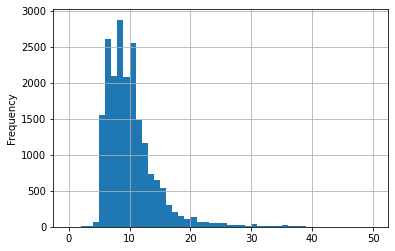

In [802]:
# Изучаем площадь кухни

display(data['kitchen_area'].describe())
data['kitchen_area'].plot(kind='hist', bins=50, range=(0,50),grid=True)

*Средняя площадь кухни составляем 10 кв.м., площадь более 20 кв.м. встречается все реже, не говоря уже о значении более 30-ти кв. м - такие можно считать единичными показателями*

count    19843.000000
mean         1.996120
std          0.900411
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

<AxesSubplot:ylabel='Frequency'>

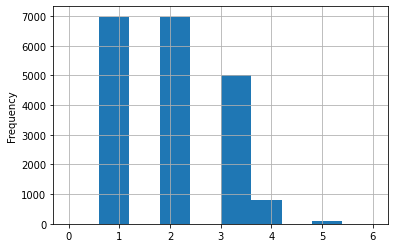

In [803]:
#Изучаем кол-во комнат

display(data['rooms'].describe())
data['rooms'].plot(kind='hist', range=(0,6), grid=True)

count    12614.000000
mean         2.717952
std          0.604701
min          1.000000
25%          2.500000
50%          2.640000
75%          2.780000
max         25.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:ylabel='Frequency'>

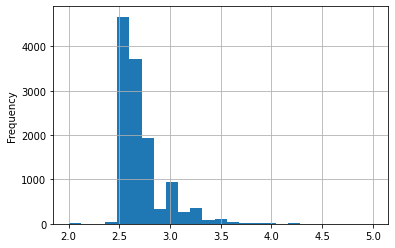

In [804]:
# Изучаем высоту потолков

display(data['ceiling_height'].describe())
data['ceiling_height'].plot(kind='hist', bins=25, range=(2,5), grid=True)

*Средняя высота потолков 2,77 м, в то время как медианное значение высоты - 2,65 м*

[1.0, 2.3, 2.4, 2.45, 2.46, 2.48, 2.53, 2.62, 2.63, 2.7, nan, 1.2, 1.75, 2.0, 2.2, 2.25, 2.47, 2.49, 2.5, 2.51, 2.52, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.3, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.42, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.59, 3.6, 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.7, 3.75, 3.78, 3.8, 3.83, 3.84, 3.85, 3.88, 3.9, 3.93, 3.95, 3.98, 4.0, 4.06, 4.1, 4.15, 4.19, 4.2, 4.25, 4.3, 4.37, 4.5, 4.7, 4.8, 8.0, 8.3, 14.0, 20.0, 22.6, 24.0, 25.0]


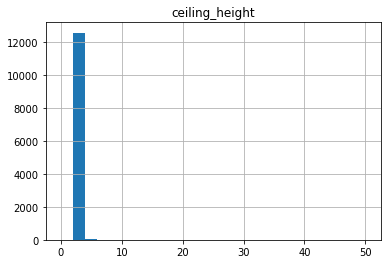

In [805]:
data.hist('ceiling_height', bins=25, range=(0,50))
ch_unique = sorted(data['ceiling_height'].unique())
print(ch_unique)

[2.25, 2.3, 2.4, 2.45, 2.46, 2.48, 2.53, 2.59, 2.62, 2.66, 2.7, nan, 2.47, 2.49, 2.5, 2.51, 2.52, 2.54, 2.55, 2.56, 2.57, 2.58, 2.6, 2.61, 2.63, 2.64, 2.65, 2.67, 2.68, 2.69, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.3, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.42, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.59, 3.6, 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.7, 3.75, 3.78, 3.8, 3.83, 3.84, 3.85, 3.88, 3.9, 3.93, 3.95, 3.98, 4.0, 4.06, 4.1, 4.15, 4.19, 4.2, 4.25, 4.3, 4.37, 4.5, 4.7, 4.8]


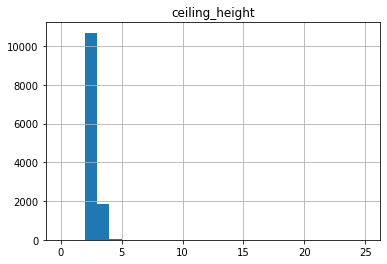

In [806]:
data.drop(index = data.query('ceiling_height < 2.25').index, inplace = True)
data.drop(index = data.query('5 < ceiling_height <= 25').index, inplace = True)
ch_unique = sorted(data['ceiling_height'].unique())
data.hist('ceiling_height', bins=25, range=(0,25))
print(ch_unique)

count    19818.000000
mean         0.627258
std          0.969473
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

<AxesSubplot:ylabel='Frequency'>

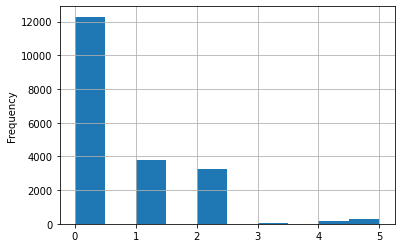

In [807]:
# Изучаем площадь балконов

display(data['balcony'].describe())
data['balcony'].plot(kind='hist', grid=True)

count    19818.000000
mean         5.886971
std          4.845157
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot:ylabel='Frequency'>

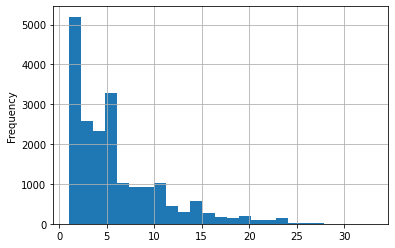

In [808]:
# Изучаем этажность квартиры

display(data['floor'].describe())
data['floor'].plot(kind='hist', bins=25, grid=True)

*Средний этаж квартиры - 5й, а медианное значение этажа такой квартиры - 4*

count    19818.000000
mean        10.726915
std          6.549442
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

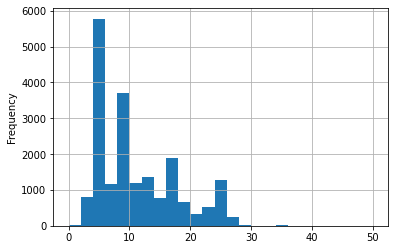

In [809]:
# Изучаем общую этажность домов

display(data['floors_total'].describe())
data['floors_total'].plot(kind='hist', bins=25,range=(0,50), grid=True)

*Средняя этажность домов - 10, почти совпадает с медианным значением - 9*

In [810]:
# Изучаем этажность квартиры: дополнение
def categoring_floor(index):
    if index['floor'] == 1:
        return 'Первый'
    elif index['floor'] == index['floors_total']:
        return 'Последний'
    else:
        return 'Другой'
    
data['floor_category'] = data.apply(categoring_floor, axis=1)
# Приприменили функцию categoring_floor столбцу floor_category

[Text(0.5, 1.0, 'Зависимость цены 1 кв.м. от этажа'),
 Text(0.5, 0, 'этаж'),
 Text(0, 0.5, 'цена за 1 кв.м.')]

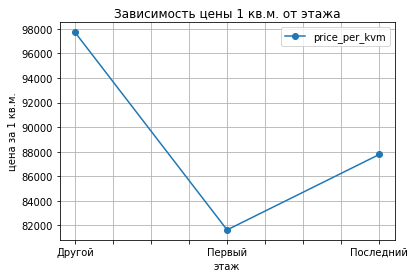

In [811]:
data.pivot_table(index='floor_category', values='price_per_kvm', aggfunc='median').reset_index().plot(
                 x='floor_category', y='price_per_kvm', grid=True, style='o-').set(
                 title='Зависимость цены 1 кв.м. от этажа', 
                 xlabel='этаж', ylabel='цена за 1 кв.м.')

[Text(0.5, 1.0, 'Зависимость общей цены от этажа'),
 Text(0.5, 0, 'этаж'),
 Text(0, 0.5, 'цена')]

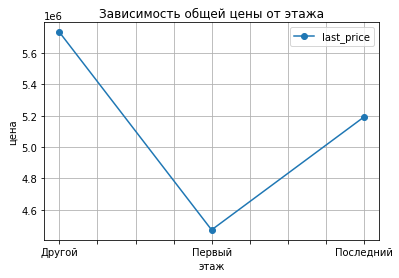

In [812]:
data.pivot_table(index='floor_category', values='last_price').reset_index().plot(
                 x='floor_category', y='last_price', grid=True, style='o-').set(
                 title='Зависимость общей цены от этажа', 
                 xlabel='этаж', ylabel='цена')

**Вывод**

Медианное время продажи - 99 дней, среднее - 182 дня. 

Большой объем квартир, проданных в течение малого времени после публикации, но так же есть и объявления с временем продажи более года

In [813]:
# Изучаем этажность квартиры: дополнение v 2.0
# Прибегнул к хитрости и промаркировал ранее созданные категории этажей
def categoring_floor_numeric(index):
    if index['floor'] == 1:
        return 1
    elif index['floor'] == index['floors_total']:
        return -1
    else:
        return 0
    
data['floor_category_num'] = data.apply(categoring_floor_numeric, axis=1)
# Приприменили функцию categoring_floor_numeric столбцу floor_category_num

count    19818.000000
mean        -0.015693
std          0.510678
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: floor_category_num, dtype: float64

[Text(0.5, 1.0, 'Распределение категорий этажей'),
 Text(0.5, 0, 'последний, другой, первый'),
 Text(0, 0.5, 'кол-во объявлений')]

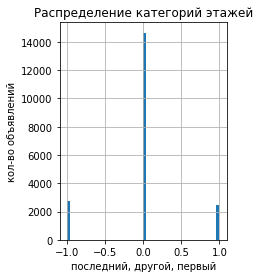

In [840]:
# Не работает из-за не числовых значений - в предыдущем блоке создал функцию-патч для исправления этого недостатка
display(data['floor_category_num'].describe())
data['floor_category_num'].plot(
    kind='hist',bins=50, range=(-1,1), grid=True, figsize=(3,4)).set(
    title='Распределение категорий этажей',xlabel='последний, другой, первый',ylabel='кол-во объявлений')

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

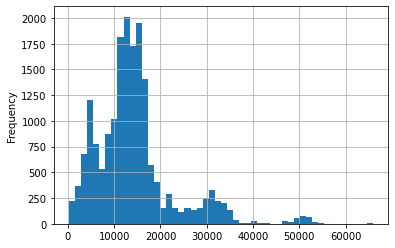

In [815]:
# Изучаем расстояние до центра города 

display(data_new['cityCenters_nearest'].describe())
data_new['cityCenters_nearest'].plot(kind='hist', bins=50, grid=True)

count    15383.000000
mean     28853.190405
std      12835.578942
min          0.000000
25%      18274.000000
50%      26938.000000
75%      37434.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

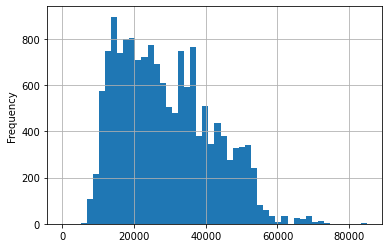

In [816]:
# Изучаем расстояние до аэропорта

display(data['airports_nearest'].describe())
data['airports_nearest'].plot(kind='hist', bins=50, grid=True)

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

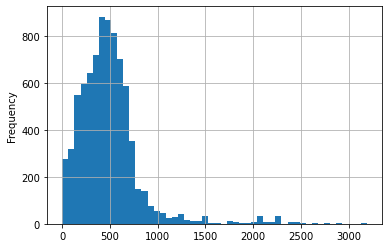

In [817]:
# Изучаем расстояние до ближайшего парка

#data_new['parks_nearest'] = data_new['parks_nearest'] / 1000
#data_new['parks_nearest'] = data_new['parks_nearest'].astype(int)

display(data_new['parks_nearest'].describe())
data_new['parks_nearest'].plot(kind='hist', bins=50, grid=True)

count    19818.000000
mean         2.545464
std          1.784662
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: week_day, dtype: float64

<AxesSubplot:ylabel='Frequency'>

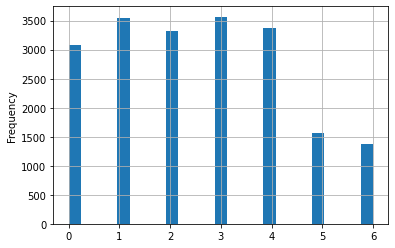

In [818]:
# Изуяение дня публикации 

display(data['week_day'].describe())
display(data['week_day'].plot(kind='hist', bins=25, grid=True))

count    19818.000000
mean         6.428499
std          3.468027
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

<AxesSubplot:ylabel='Frequency'>

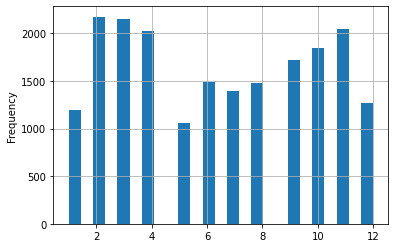

In [819]:
# Изуяение месяца публикации 

display(data['month'].describe())
data['month'].plot(kind='hist', bins=25, grid=True)

### Изучение времени продажи квартиры 

count    17221.000000
mean       181.568492
std        218.611002
min          1.000000
25%         44.000000
50%         99.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


Время продажи (медиана): 99
Время продажи (среднее): 182


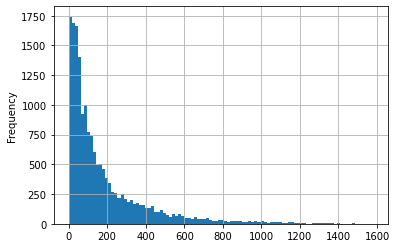

In [820]:
# Изучение времени продажи квартиры 

display(data['days_exposition'].describe())
data['days_exposition'].plot(kind='hist', bins=100, grid=True)
print()
print('Время продажи (медиана):', round(data['days_exposition'].median()))
print('Время продажи (среднее):', round(data['days_exposition'].mean()))

In [821]:
data.query('~days_exposition.isna()')['days_exposition'].describe()

count    17221.000000
mean       181.568492
std        218.611002
min          1.000000
25%         44.000000
50%         99.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

### Изучение факторов влияния на стоимость квартиры

Кореляция цены за кв. м и общей площади: 0.14


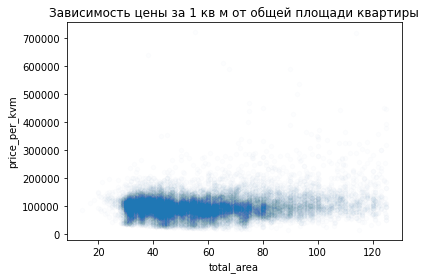

In [822]:
# Изучение факторов влияния на стоимость квартиры

# Зависимость цены за 1 кв м от общей площади
data.plot(x='total_area', y='price_per_kvm', kind='scatter', alpha=0.01,
                       title='Зависимость цены за 1 кв м от общей площади квартиры')

#print(data.pivot_table(index='total_area', values=['total_area', 'price_per_kvm']).corr())
print('Кореляция цены за кв. м и общей площади:', (data['total_area'].corr(data['price_per_kvm'])).round(2))


Кореляция цены и общей площади: 0.7


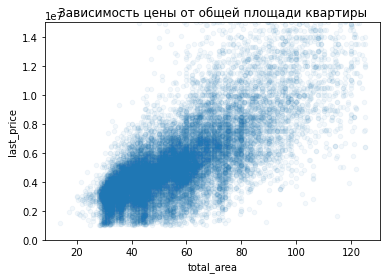

In [823]:
# Зависимость цены от общей площади

data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.05, ylim=(0,15.0e+6),
                       title='Зависимость цены от общей площади квартиры')
print('Кореляция цены и общей площади:',(data['total_area'].corr(data['last_price'])).round(2))


Кореляция цены и жилой площади: 0.57


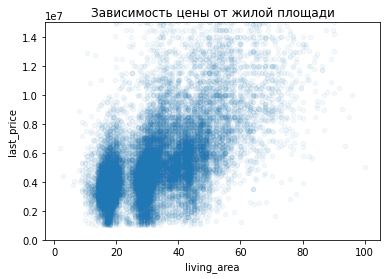

In [824]:
# Зависимость цены от жилой площади

data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.05,ylim=(0,15.0e+6),
                       title='Зависимость цены от жилой площади')
print('Кореляция цены и жилой площади:',(data['living_area'].corr(data['last_price'])).round(2))


Кореляция цены и площади кухни: 0.52


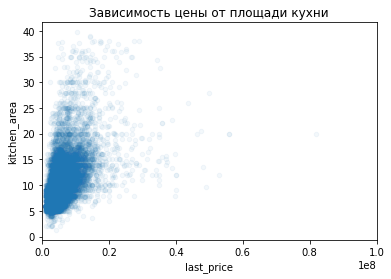

In [825]:
# Зависимость цены от площади кухни

data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.05, xlim=(0,1.0e+8),
                       title='Зависимость цены от площади кухни')
print('Кореляция цены и площади кухни:',(data['kitchen_area'].corr(data['last_price'])).round(2))


Кореляция цены и количества комнат: 0.4


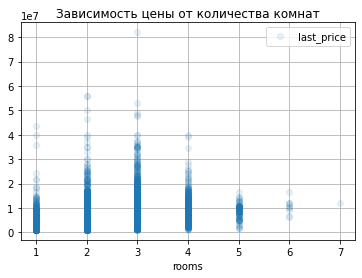

In [826]:
# Зависимость цены от количества комнат

data.plot(x='rooms', y='last_price', style='o',alpha=0.1,grid=True,
                       title='Зависимость цены от количества комнат')

print('Кореляция цены и количества комнат:',(data['rooms'].corr(data['last_price'])).round(2))


[Text(0.5, 1.0, 'Зависимость цены от количества комнат'),
 Text(0.5, 0, 'количество комнат'),
 Text(0, 0.5, 'цена')]

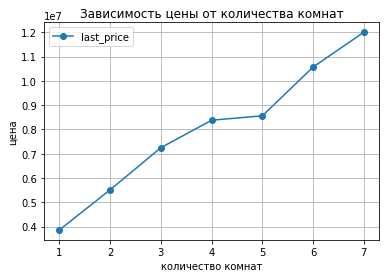

In [827]:
data.pivot_table(index='rooms', values='last_price', aggfunc='mean').reset_index().plot(
                      x='rooms', y='last_price', grid=True, style='o-').set(
                      title='Зависимость цены от количества комнат', 
                      xlabel='количество комнат', ylabel='цена')

[Text(0.5, 1.0, 'Зависимость цены за кв метр от количества комнат'),
 Text(0.5, 0, 'количество комнат'),
 Text(0, 0.5, 'цена за 1 кв м')]

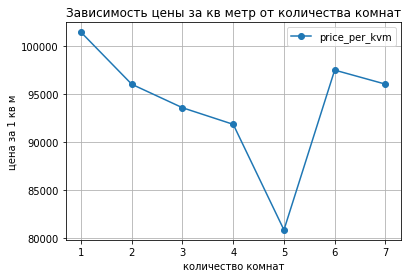

In [828]:
data.pivot_table(index='rooms', values='price_per_kvm', aggfunc='mean').reset_index().plot(
                      x='rooms', y='price_per_kvm', grid=True, style='o-').set(
                      title='Зависимость цены за кв метр от количества комнат', 
                      xlabel='количество комнат', ylabel='цена за 1 кв м')

Кореляция цены и этажа квартиры: 0.08


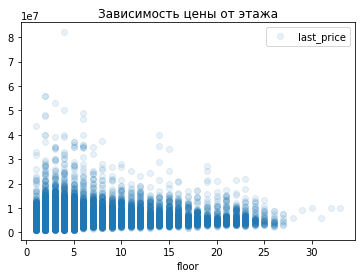

In [829]:
# Зависимость цены от этажа

data.plot(x='floor', y='last_price', style='o',alpha=0.1,
                       title='Зависимость цены от этажа')

print('Кореляция цены и этажа квартиры:',(data['floor'].corr(data['last_price'])).round(2))

[Text(0.5, 1.0, 'Зависимость общей цены от этажа'),
 Text(0.5, 0, 'этаж'),
 Text(0, 0.5, 'цена')]

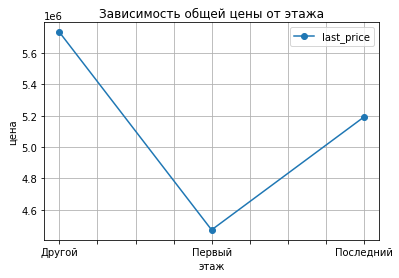

In [830]:
data.pivot_table(index='floor_category', values='last_price').reset_index().plot(
                 x='floor_category', y='last_price', grid=True, style='o-').set(
                 title='Зависимость общей цены от этажа', 
                 xlabel='этаж', ylabel='цена')

Кореляция цены и месяца продажи: 0.01


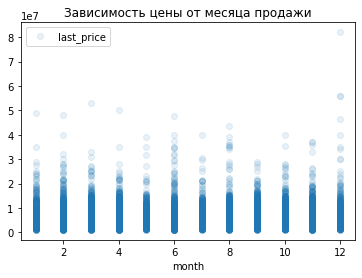

In [831]:
# Зависимость цены от месяца продажи

data.plot(x='month', y='last_price', style='o',alpha=0.1,
                       title='Зависимость цены от месяца продажи')

print('Кореляция цены и месяца продажи:',(data['month'].corr(data['last_price'])).round(2))

[Text(0.5, 1.0, 'Усредненная зависимость цены от месяца продажи'),
 Text(0.5, 0, 'месяц размещения'),
 Text(0, 0.5, 'цена')]

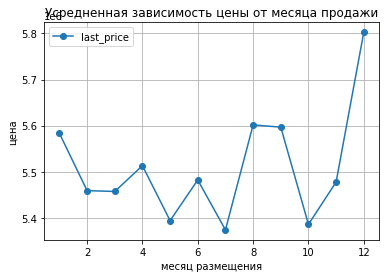

In [832]:
data.pivot_table(index='month', values='last_price', aggfunc='mean').reset_index().plot(
                      x='month', y='last_price', grid=True, style='o-').set(
                      title='Усредненная зависимость цены от месяца продажи', 
                      xlabel='месяц размещения', ylabel='цена')

Кореляция цены и года продажи: -0.02


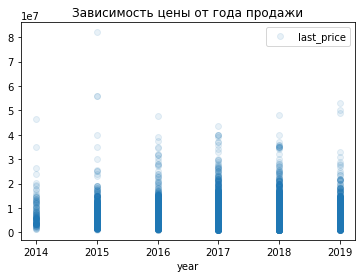

In [833]:
# Зависимость цены от года продажи

data.plot(x='year', y='last_price', style='o',alpha=0.1,
                       title='Зависимость цены от года продажи')

print('Кореляция цены и года продажи:',(data['year'].corr(data['last_price'])).round(2))

[Text(0.5, 1.0, 'Усредненная зависимость цены от года продажи'),
 Text(0.5, 0, 'год продажи'),
 Text(0, 0.5, 'цена')]

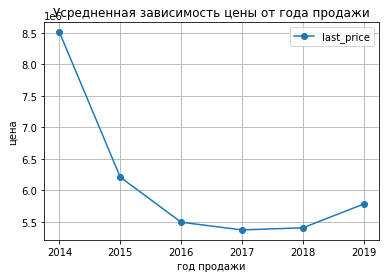

In [834]:
data.pivot_table(index='year', values='last_price', aggfunc='mean').reset_index().plot(
                      x='year', y='last_price', grid=True, style='o-').set(
                      title='Усредненная зависимость цены от года продажи', 
                      xlabel='год продажи', ylabel='цена')

### Средняя цена одного кв. метра в топ 10 населенных пунктах


In [835]:
# Изучение средней цены одного кв. метра в топ 10 населенных пунктах

top_10 = data['locality_name'].value_counts().head(10)
top_10_price = data.query('locality_name in (@top_10.index)').pivot_table(values='price_per_kvm', index='locality_name')
top_10_price = top_10_price.astype(int)
top_10_price.sort_values('price_per_kvm', ascending=False)

,price_per_kvm
locality_name,
Санкт-Петербург,110354
Пушкин,102950
деревня Кудрово,92248
посёлок Парголово,90756
посёлок Мурино,85419
Петергоф,83318
посёлок Шушары,78408
Колпино,75167
Всеволожск,69058


### Изучение расстояния до центра

<AxesSubplot:xlabel='center_long'>

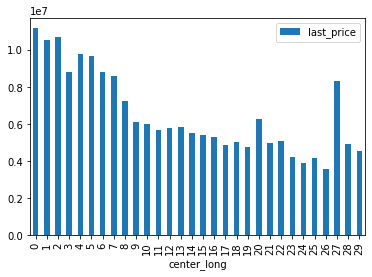

In [836]:
#data.plot(kind='bar',x='center_long', y='last_price', title='Зависимость цены от удаленности от центра города')
#не работает

data[data['locality_name']=='Санкт-Петербург'].pivot_table(
    index='center_long', values='last_price', aggfunc='mean').plot(kind='bar')


Высокая цена на недвижимость наблюдается в пределах 1-7 км от центра, пик цены на 8 и 27 км возможно объяснить тем, что там расположена элитная недвижимость  

**Вывод**

Наибольшая цена за кв. метр в Санкт_Петербурге, затем г. Пушкин и д. Кудрово. Затем топ-5 занимают районы Санкт_Петербурга

## Общий вывод

*Большинство квартир площадью менее 100 кв. м, средняя цена большинства квартир составляет 6,5 млн, а квартир стоимостью больее 15 млн уже сравнительно меньше. Встречаются и аномальыне квартиры-одиночки - с площадью более 150 кв м и ценой свыше 50 млн, но таких буквально единицы*

*Наиболее распространены квартиры с жилой площадью от 10 до 50 кв м, далее квартир с больше площадью становится стремительно меньше и вот уже с жилой площадью более 100 кв. м можно считать редкими*

*Наиболее распространены квартиры с 1-3 комнатами, с 4 и 5 - уже напорядок меньше*

*Средняя высота потолка достигает 2,77 м, встречаются аномальные значения свыше 25, но это вероятно закрались ошибки в данных, может, пропущеная запятая или проблемы при выгрузке или при конвертациях, как предположение*

*Средняя площадь кухни находится в диапазоне от 5 до 12 кв.м., площадь более 20 кв.м. встречается все реже, не говоря уже о значении более 30-ти кв. м - такие можно считать единичными показателями*

*Среднее время продажи - 181 деь, быстрым временем продажи можно считать показатель до 100 дней*

*Что касается корреляций, то высокий показатель имеет отношение цены с общей площадью квартиры, чуть меньшую, но значимую умеренную корреляцию составляют жилая площадь, площадь кухни и количество комнат.А этажность квартиры имеет едва заметную кореляцию, время года и день недели продажи так же никак не влияет на ценовое изменение*

